# Library import

In [1]:
# 필요 library들을 import합니다.
import os
from typing import Tuple, Any, Callable, List, Optional, Union

import cv2
import timm
import torch
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
import random
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import logging
import time



# 랜덤 시드 고정

In [2]:
import torch
import numpy as np
import random

# 시드 고정
def set_seed(seed=42):
    random.seed(seed)  # 파이썬의 기본 random 시드 고정
    np.random.seed(seed)  # 넘파이 시드 고정
    torch.manual_seed(seed)  # 파이토치 시드 고정
    torch.cuda.manual_seed(seed)  # CUDA 시드 고정 (GPU 사용 시)
    torch.cuda.manual_seed_all(seed)  # 여러 GPU를 사용할 경우 시드 고정
    torch.backends.cudnn.deterministic = True  # 일관된 결과를 위해 설정
    torch.backends.cudnn.benchmark = False  # 성능을 희생하고 일관성을 얻음

set_seed(42)  # 원하는 시드 값으로 고정

In [3]:
torch.cuda.empty_cache()

# Dataset Class

In [4]:
class CustomDataset(Dataset):
    def __init__(
        self,
        root_dir: str,
        info_df: pd.DataFrame,
        transform: Callable,
        is_inference: bool = False
    ):
        # 데이터셋의 기본 경로, 이미지 변환 방법, 이미지 경로 및 레이블을 초기화합니다.
        self.root_dir = root_dir  # 이미지 파일들이 저장된 기본 디렉토리
        self.transform = transform  # 이미지에 적용될 변환 처리
        self.is_inference = is_inference # 추론인지 확인
        self.image_paths = info_df['image_path'].tolist()  # 이미지 파일 경로 목록

        if not self.is_inference:
            self.targets = info_df['target'].tolist()  # 각 이미지에 대한 레이블 목록

    def __len__(self) -> int:
        # 데이터셋의 총 이미지 수를 반환합니다.
        return len(self.image_paths)

    def __getitem__(self, index: int) -> Union[Tuple[torch.Tensor, int], torch.Tensor]:
        # 주어진 인덱스에 해당하는 이미지를 로드하고 변환을 적용한 후, 이미지와 레이블을 반환합니다.
        img_path = os.path.join(self.root_dir, self.image_paths[index])  # 이미지 경로 조합
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # 이미지를 BGR 컬러 포맷의 numpy array로 읽어옵니다.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR 포맷을 RGB 포맷으로 변환합니다.
        image = self.transform(image)  # 설정된 이미지 변환을 적용합니다.

        if self.is_inference:
            return image
        else:
            target = self.targets[index]  # 해당 이미지의 레이블
            return image, target  # 변환된 이미지와 레이블을 튜플 형태로 반환합니다.

# Transform Class

In [5]:
class TorchvisionTransform:
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 텐서 변환, 정규화
        common_transforms = [
            transforms.Resize((224, 224)),  # 이미지를 224x224 크기로 리사이즈
            transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ]

        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 색상 조정 추가
            self.transform = transforms.Compose(
                [
                    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 이미지를 수평 뒤집기
                    transforms.RandomRotation(15),  # 최대 15도 회전
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기 및 대비 조정
                ] + common_transforms
            )
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.transform = transforms.Compose(common_transforms)

    def __call__(self, image: np.ndarray) -> torch.Tensor:
        image = Image.fromarray(image)  # numpy 배열을 PIL 이미지로 변환

        transformed = self.transform(image)  # 설정된 변환을 적용

        return transformed  # 변환된 이미지 반환

In [6]:
# 랜덤 워터마크 추가 증강
class RandomAddWatermark(A.ImageOnlyTransform):
    def __init__(self, watermark_text = "defualt", min_font_scale=0.5, max_font_scale=2.0, min_thickness=2, max_thickness=4, always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.watermark_text = watermark_text
        self.min_font_scale = min_font_scale
        self.max_font_scale = max_font_scale
        self.min_thickness = min_thickness
        self.max_thickness = max_thickness
        self.wartermark_list = ["shutterstock", "CanStock", "iStock", "VectorStock", "Adobe Stock"]
    
    def apply(self, image, **params):
        image = image.copy()

        # 랜덤한 폰트 스타일, 크기와 두께, 워터마크 글자 선택
        fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_DUPLEX, cv2.FONT_HERSHEY_TRIPLEX]
        fonts_idx = random.randint(0, 3)
        font_scale = random.uniform(self.min_font_scale, self.max_font_scale)
        font_color = random.uniform(0, 255)
        thickness = random.randint(self.min_thickness, self.max_thickness)
        wartermark_idx = random.randint(0, 4)
        transparency = random.gauss(0, 1)
        self.watermark_text = self.wartermark_list[wartermark_idx]
        
        # 이미지의 크기를 가져옴
        h, w, _ = image.shape
        
        # 랜덤한 위치 선택 (워터마크가 이미지 밖으로 나가지 않도록 보장)
        text_size = cv2.getTextSize(text=self.watermark_text, fontFace=fonts[fonts_idx], fontScale=font_scale, thickness=thickness)[0]

        # 텍스트가 이미지보다 큰 경우 폰트 크기 조정
        if text_size[1] >= h - 10:
            font_scale = h / text_size[1] * 0.8
            text_size = cv2.getTextSize(text=self.watermark_text, fontFace=fonts[fonts_idx], fontScale=font_scale, thickness=thickness)[0]
        if text_size[0] >= w - 10:
            font_scale = w / text_size[0] * 0.8
            text_size = cv2.getTextSize(text=self.watermark_text, fontFace=fonts[fonts_idx], fontScale=font_scale, thickness=thickness)[0]
        
        x = random.randint(0, w - text_size[0] - 10)  # 10픽셀 여유
        y = random.randint(text_size[1] + 10, h - 10)  # 10픽셀 여유
        
        # 워터마크 추가
        cv2.putText(image, text=self.watermark_text, org=(x, y), fontFace=fonts[fonts_idx], fontScale=font_scale, color=(font_color, font_color, font_color, transparency), thickness=thickness, lineType=cv2.LINE_AA)

        return image

    def apply_to_bbox(self, bbox, **params):
        return bbox

    def apply_to_mask(self, mask, **params):
        return mask

In [7]:
# 각 증강된 이미지 시각화
def VisualizeAgumentationImage(csv_file, image_dir, augmentaion, num_samples=4, figsize=(20, 20)):
    """
    CSV 파일에서 이미지 경로를 무작위로 선택해 그 이미지와 증강된 이미지를 시각화하는 함수.

    Parameters:
    - csv_file: 이미지 경로와 라벨이 있는 CSV 파일 경로
    - image_dir: 실제 이미지 파일이 있는 디렉토리 경로
    - augmentaion: 확인할 증강 메서드
    - num_samples: 시각화할 이미지 개수 (기본값 4)
    - figsize: 출력 이미지 크기 (기본값 (20, 20))
    """

    # CSV 파일 읽기
    df = pd.read_csv(csv_file)

    # output_df 열에서 무작위로 num_samples 개 선택
    random_samples = df.sample(n=num_samples)

    plt.figure(figsize=figsize)

    for i, row in enumerate(random_samples.itertuples()):
        # 이미지 경로 가져오기
        img_path = f"{image_dir}/{row.image_path}"

        # OpenCV로 이미지 읽기 (BGR로 읽으므로 RGB로 변환)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 이미지 시각화
        plt.subplot(int(np.sqrt(num_samples)) * 2, int(np.sqrt(num_samples * 2)) * 2, i * 2 + 1 )
        plt.imshow(image)
        plt.axis('off')

        # 원하는 증강 설정
        transform = A.Compose([
            augmentaion, # 시각화할 증강
            ToTensorV2()  # PyTorch 텐서로 변환
        ])
        augmented = transform(image=image)
        augmented_image = augmented['image']
        augmented_image = augmented_image.permute(1, 2, 0)

        # 증강된 이미지 시각화
        plt.subplot(int(np.sqrt(num_samples)) * 2, int(np.sqrt(num_samples * 2)) * 2, i * 2 + 2)
        plt.imshow(augmented_image)
        plt.axis('off')

    plt.show()

In [8]:
# traindata_dir = "./../../data/train"
# traindata_info_file = "./../../data/train.csv"
# VisualizeAgumentationImage(traindata_info_file, traindata_dir, A.InvertImg(p=1))

In [9]:
class AlbumentationsTransform:
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 정규화, 텐서 변환
        common_transforms = [
            A.Resize(224, 224),  # 이미지를 224x224 크기로 리사이즈
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
            ToTensorV2()  # albumentations에서 제공하는 PyTorch 텐서 변환
        ]

        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 랜덤 밝기 및 대비 조정 추가
            self.transform = A.Compose(
                [
                    A.HorizontalFlip(p=0.5),  # 50% 확률로 이미지를 수평 뒤집기
                    # A.VerticalFlip(p=0.1), # 10% 확률로 이미지를 수직 뒤집기
                    A.Rotate(limit=15),  # 최대 15도 회전
                    A.RandomBrightnessContrast(p=0.2),  # 밝기 및 대비 무작위 조정
                    # A.InvertImg(p=0.1), # 10% 확률로 이미지 밝기 반전
                    # RandomAddWatermark(p=0.5) # 랜덤 워터마크 생성
                ] + common_transforms
            )
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.transform = A.Compose(common_transforms)

    def __call__(self, image) -> torch.Tensor:
        # 이미지가 NumPy 배열인지 확인
        if not isinstance(image, np.ndarray):
            raise TypeError("Image should be a NumPy array (OpenCV format).")

        # 이미지에 변환 적용 및 결과 반환
        transformed = self.transform(image=image)  # 이미지에 설정된 변환을 적용

        return transformed['image']  # 변환된 이미지의 텐서를 반환

In [10]:
class TransformSelector:
    """
    이미지 변환 라이브러리를 선택하기 위한 클래스.
    """
    def __init__(self, transform_type: str):

        # 지원하는 변환 라이브러리인지 확인
        if transform_type in ["torchvision", "albumentations"]:
            self.transform_type = transform_type

        else:
            raise ValueError("Unknown transformation library specified.")

    def get_transform(self, is_train: bool):

        # 선택된 라이브러리에 따라 적절한 변환 객체를 생성
        if self.transform_type == 'torchvision':
            transform = TorchvisionTransform(is_train=is_train)

        elif self.transform_type == 'albumentations':
            transform = AlbumentationsTransform(is_train=is_train)

        return transform

# Model Class

In [11]:
class SimpleCNN(nn.Module):
    """
    간단한 CNN 아키텍처를 정의하는 클래스.
    """
    def __init__(self, num_classes: int):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # 순전파 함수 정의
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [12]:
class TorchvisionModel(nn.Module):
    """
    Torchvision에서 제공하는 사전 훈련된 모델을 사용하는 클래스.
    """
    def __init__(
        self,
        model_name: str,
        num_classes: int,
        pretrained: bool
    ):
        super(TorchvisionModel, self).__init__()
        self.model = models.__dict__[model_name](pretrained=pretrained)

        # 모델의 최종 분류기 부분을 사용자 정의 클래스 수에 맞게 조정
        if 'fc' in dir(self.model):
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)

        elif 'classifier' in dir(self.model):
            num_ftrs = self.model.classifier[-1].in_features
            self.model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        return self.model(x)

In [13]:
class TimmModel(nn.Module):
    """
    Timm 라이브러리를 사용하여 다양한 사전 훈련된 모델을 제공하는 클래스.
    """
    def __init__(
        self,
        model_name: str,
        num_classes: int,
        pretrained: bool
    ):
        super(TimmModel, self).__init__()
        self.model = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=num_classes
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        return self.model(x)

In [14]:
class ModelSelector:
    """
    사용할 모델 유형을 선택하는 클래스.
    """
    def __init__(
        self,
        model_type: str,
        num_classes: int,
        **kwargs
    ):

        # 모델 유형에 따라 적절한 모델 객체를 생성
        if model_type == 'simple':
            self.model = SimpleCNN(num_classes=num_classes)

        elif model_type == 'torchvision':
            self.model = TorchvisionModel(num_classes=num_classes, **kwargs)

        elif model_type == 'timm':
            self.model = TimmModel(num_classes=num_classes, **kwargs)

        else:
            raise ValueError("Unknown model type specified.")

    def get_model(self) -> nn.Module:

        # 생성된 모델 객체 반환
        return self.model

# Loss Class

In [15]:
class Loss(nn.Module):
    """
    모델의 손실함수를 계산하는 클래스.
    """
    def __init__(self):
        super(Loss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(
        self,
        outputs: torch.Tensor,
        targets: torch.Tensor
    ) -> torch.Tensor:

        return self.loss_fn(outputs, targets)

# Trainer Class

In [16]:
class Trainer:
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        train_loader: DataLoader,
        val_loader: DataLoader,
        optimizer: optim.Optimizer,
        scheduler: optim.lr_scheduler,
        loss_fn: torch.nn.modules.loss._Loss,
        epochs: int,
        weight_path: str,
        log_path: str,
        tensorboard_path: str
    ):
        # 클래스 초기화: 모델, 디바이스, 데이터 로더 등 설정
        self.model = model  # 훈련할 모델
        self.device = device  # 연산을 수행할 디바이스 (CPU or GPU)
        self.train_loader = train_loader  # 훈련 데이터 로더
        self.val_loader = val_loader  # 검증 데이터 로더
        self.optimizer = optimizer  # 최적화 알고리즘
        self.scheduler = scheduler # 학습률 스케줄러
        self.loss_fn = loss_fn  # 손실 함수
        self.epochs = epochs  # 총 훈련 에폭 수
        self.weight_path = weight_path  # 모델 저장 경로
        self.log_path = log_path # 로그 저장 경로
        self.tensorboard_path = tensorboard_path # 로그 저장 경로
        self.best_models = [] # 가장 좋은 상위 3개 모델의 정보를 저장할 리스트
        self.lowest_loss = float('inf') # 가장 낮은 Loss를 저장할 변수

    def save_model(self, epoch, loss):
        # 모델 저장 경로 설정
        os.makedirs(self.weight_path, exist_ok=True)

        # 현재 에폭 모델 저장
        current_model_path = os.path.join(self.weight_path, f'model_epoch_{epoch}_loss_{loss:.4f}.pt')
        torch.save(self.model.state_dict(), current_model_path)

        # 최상위 3개 모델 관리
        self.best_models.append((loss, epoch, current_model_path))
        self.best_models.sort()
        if len(self.best_models) > 3:
            _, _, path_to_remove = self.best_models.pop(-1)  # 가장 높은 손실 모델 삭제
            if os.path.exists(path_to_remove):
                os.remove(path_to_remove)

        # 가장 낮은 손실의 모델 저장
        if loss < self.lowest_loss:
            self.lowest_loss = loss
            best_model_path = os.path.join(self.weight_path, 'best_model.pt')
            torch.save(self.model.state_dict(), best_model_path)
            print(f"Save {epoch}epoch result. Loss = {loss:.4f}")

    def train_epoch(self, epoch) -> float:
        # 한 에폭 동안의 훈련을 진행
        self.model.train()

        total_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(self.train_loader, desc="Training", leave=False)

        for images, targets in progress_bar:
            images, targets = images.to(self.device), targets.to(self.device)
            
            # # 학습되는 image 확인
            # image_np = images[0].cpu().numpy()  # tensor를 numpy array로 변환
            # image_np = np.transpose(image_np, (1, 2, 0))  # (C, H, W)에서 (H, W, C)로 변환 필요
            # mean = np.array([0.485, 0.456, 0.406])
            # std = np.array([0.229, 0.224, 0.225])

            # # 원본 이미지 복원
            # denormalized_image = image_np * std + mean
            # # 픽셀 값을 [0, 255] 범위로 변환
            # denormalized_image = np.clip(denormalized_image * 255, 0, 255).astype(np.uint8)
            # # 이미지 저장
            # cv2.imwrite(f"{epoch}epoch_image.jpg", denormalized_image)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.loss_fn(outputs, targets)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
            logits = F.softmax(outputs, dim=1)
            preds = logits.argmax(dim=1)
            total += targets.size(0)
            correct += (preds == targets).sum().item()
        return total_loss / len(self.train_loader), correct / total * 100

    def validate(self) -> float:
        # 모델의 검증을 진행
        self.model.eval()

        total_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(self.val_loader, desc="Validating", leave=False)

        with torch.no_grad():
            for images, targets in progress_bar:
                images, targets = images.to(self.device), targets.to(self.device)

                outputs = self.model(images)
                loss = self.loss_fn(outputs, targets)
                total_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())
                logits = F.softmax(outputs, dim=1)
                preds = logits.argmax(dim=1)
                total += targets.size(0)
                correct += (preds == targets).sum().item()

        return total_loss / len(self.val_loader), correct / total * 100

    def train(self) -> None:
        # 전체 훈련 과정을 관리
        logging.basicConfig(
            level=logging.INFO,  # 로그 레벨을 INFO로 설정
            format='%(asctime)s - %(levelname)s - %(message)s',  # 로그 형식
            handlers=[
                logging.FileHandler(self.log_path),  # 로그를 파일에 기록
                logging.StreamHandler()  # 로그를 콘솔에도 출력
            ]
        )
        writer = SummaryWriter(log_dir=self.tensorboard_path)

        logger = logging.getLogger()

        # 전체 훈련 과정을 관리
        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}/{self.epochs}")

            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate()
            logger.info(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}, Validation Loss: {val_loss:.4f}, Validataion Accuracy: {val_acc:.2f}\n")

            self.save_model(epoch, val_loss)
            self.scheduler.step()

            writer.add_scalar('Loss/train', train_loss, epoch)  # 훈련 손실 기록
            writer.add_scalar('Accuracy/train', train_acc, epoch)  # 훈련 손실 기록
            writer.add_scalar('Loss/validation', val_loss, epoch)  # 검증 손실 기록
            writer.add_scalar('Accuracy/validation', val_acc, epoch)  # 검증 손실 기록

        writer.close()  

In [17]:
def setup_directories(save_rootpath):
    # 가중치, 로그, TensorBoard 경로 설정
    weight_dir = os.path.join(save_rootpath, 'weights')
    log_dir = os.path.join(save_rootpath, 'logs')
    tensorboard_dir = os.path.join(save_rootpath, 'tensorboard')

    # 디렉토리 생성 (존재하지 않으면 생성)
    os.makedirs(weight_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(tensorboard_dir, exist_ok=True)

    return weight_dir, log_dir, tensorboard_dir

# Model Training

In [18]:
# 학습에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
print(torch.cuda.is_available())

True


In [20]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정.
traindata_dir = "./../../data/train"
traindata_info_file = "./../../data/train.csv"

In [21]:
# 로그 경로 설정
weight_dir, log_dir, tensorboard_dir = setup_directories("Experiments/debug")
logfile = os.path.join(log_dir, "trianlog.log")

In [22]:
# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
train_info = pd.read_csv(traindata_info_file)

# 총 class의 수를 측정.
num_classes = len(train_info['target'].unique())

# 각 class별로 8:2의 비율이 되도록 학습과 검증 데이터를 분리.
train_df, val_df = train_test_split(
    train_info,
    test_size=0.2,
    stratify=train_info['target']
)

In [23]:
# 학습에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "albumentations"
)
train_transform = transform_selector.get_transform(is_train=True)
val_transform = transform_selector.get_transform(is_train=False)

# 학습에 사용할 Dataset을 선언.
train_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=train_df,
    transform=train_transform
)
val_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=val_df,
    transform=val_transform
)

# 학습에 사용할 DataLoader를 선언.
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False
)

In [24]:
# 학습에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='simple',
    num_classes=num_classes,
    model_name='timm/resnext50_32x4d.fb_swsl_ig1b_ft_in1k',
    pretrained=True
)
model = model_selector.get_model()

# 선언된 모델을 학습에 사용할 장비로 셋팅.
model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=500, bias=True)
  (relu): ReLU()
)

In [25]:
print(sum(p.numel() for p in model.parameters()))

103367220


In [26]:
# import torch.nn as nn

# num_features = model.model.fc.in_features

# # 새로운 MLP HEAD 레이어 추가
# model.model.fc = nn.Sequential( # MLP HEAD
#     nn.Linear(num_features, 1024, bias=True),  # 추가할 FC 레이어
#     nn.GELU(approximate='none'),
#     nn.Dropout(p=0.0, inplace=False),
#     nn.Identity(),
#     nn.Linear(in_features=1024, out_features=500, bias=True) # 추가할 FC 레이어
# )

In [27]:
# # 전이 학습 - 특정 레이어 이후의 파라미터만 학습 가능하도록 설정
# specific_layer_name = 'layer4'  # 학습 가능하게 설정할 첫 번째 레이어의 이름을 설정

# # 모든 파라미터를 학습 불가로 설정
# for n, p in model.model.named_parameters():
#     print("freeze", n)
#     p.requires_grad = False

In [28]:

# # 모든 파라미터를 학습 불가로 설정
# for n, p in model.model.named_parameters():
#     print("freeze", n)
#     p.requires_grad = False

# # 전이 학습 - 특정 레이어 이후의 파라미터만 학습 가능하도록 설정
# specific_layer_name = 'blocks.15.norm1.weight'  # 학습 가능하게 설정할 첫 번째 레이어의 이름을 설정

# # 특정 레이어 이후의 파라미터를 학습 가능하게 설정
# enable_grad = False
# for name, param in model.model.named_parameters():
#     if specific_layer_name in name:  # 특정 레이어에 도달했을 때
#         param.requires_grad = True
#         enable_grad = True
#         print("unfreeze", name)
#     if enable_grad:
#         print("unfreeze", name)
#         param.requires_grad = True

In [29]:
# # 전이 학습
# for n,p in model.model.named_parameters():
#     p.requires_grad=False
# # 추가한 FC 레이어의 파라미터만 학습 가능하도록 설정
# for n,p in model.model.fc.named_parameters():
#     print("unfreeze", n)
#     p.requires_grad = True

In [30]:
model = model.to(device)

In [31]:
# 학습에 사용할 optimizer를 선언하고, learning rate를 지정
optimizer = optim.Adam(
    model.parameters(),
    lr=0.0001
)

In [32]:
# 스케줄러 초기화
scheduler_step_size = 10  # 매 10step마다 학습률 감소
scheduler_gamma = 0.1  # 학습률을 현재의 10%로 감소

# 한 epoch당 step 수 계산
steps_per_epoch = len(train_loader)

# 10 epoch마다 학습률을 감소시키는 스케줄러 선언
epochs_per_lr_decay = 10 # 10 에폭마다 0.1배
scheduler_step_size = steps_per_epoch * epochs_per_lr_decay

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=scheduler_gamma
)

In [33]:
# 학습에 사용할 Loss를 선언.
loss_fn = Loss()

In [34]:
# 앞서 선언한 필요 class와 변수들을 조합해, 학습을 진행할 Trainer를 선언.
trainer = Trainer(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    epochs=20,
    weight_path= weight_dir,
    log_path= logfile,
    tensorboard_path= tensorboard_dir
)

In [35]:
print(device)

cuda


In [36]:
trainer.train()

Epoch 1/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:28:57,540 - INFO - Epoch 1, Train Loss: 6.2007, Train Accuracy: 0.37, Validation Loss: 6.1171, Validataion Accuracy: 0.83



Save 0epoch result. Loss = 6.1171
Epoch 2/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:30:06,946 - INFO - Epoch 2, Train Loss: 5.8566, Train Accuracy: 2.44, Validation Loss: 5.6749, Validataion Accuracy: 5.22



Save 1epoch result. Loss = 5.6749
Epoch 3/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:31:15,958 - INFO - Epoch 3, Train Loss: 5.0758, Train Accuracy: 10.47, Validation Loss: 5.2455, Validataion Accuracy: 10.78



Save 2epoch result. Loss = 5.2455
Epoch 4/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:32:26,024 - INFO - Epoch 4, Train Loss: 4.1923, Train Accuracy: 22.43, Validation Loss: 5.0022, Validataion Accuracy: 16.24



Save 3epoch result. Loss = 5.0022
Epoch 5/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:33:34,874 - INFO - Epoch 5, Train Loss: 3.4234, Train Accuracy: 34.57, Validation Loss: 4.8749, Validataion Accuracy: 20.70



Save 4epoch result. Loss = 4.8749
Epoch 6/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:34:43,879 - INFO - Epoch 6, Train Loss: 2.8275, Train Accuracy: 44.98, Validation Loss: 4.8305, Validataion Accuracy: 25.32



Save 5epoch result. Loss = 4.8305
Epoch 7/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:35:51,767 - INFO - Epoch 7, Train Loss: 2.3021, Train Accuracy: 54.54, Validation Loss: 4.8661, Validataion Accuracy: 28.62



Epoch 8/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:37:00,059 - INFO - Epoch 8, Train Loss: 1.9313, Train Accuracy: 61.38, Validation Loss: 4.9917, Validataion Accuracy: 30.45



Epoch 9/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:38:08,385 - INFO - Epoch 9, Train Loss: 1.6108, Train Accuracy: 67.24, Validation Loss: 4.9490, Validataion Accuracy: 31.38



Epoch 10/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:39:15,823 - INFO - Epoch 10, Train Loss: 1.3655, Train Accuracy: 71.84, Validation Loss: 5.0142, Validataion Accuracy: 33.34



Epoch 11/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:40:23,633 - INFO - Epoch 11, Train Loss: 1.1824, Train Accuracy: 75.45, Validation Loss: 5.1406, Validataion Accuracy: 34.68



Epoch 12/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:41:32,733 - INFO - Epoch 12, Train Loss: 1.0133, Train Accuracy: 78.98, Validation Loss: 5.1433, Validataion Accuracy: 35.74



Epoch 13/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:42:41,918 - INFO - Epoch 13, Train Loss: 0.8895, Train Accuracy: 81.29, Validation Loss: 5.3196, Validataion Accuracy: 36.44



Epoch 14/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:43:50,222 - INFO - Epoch 14, Train Loss: 0.7690, Train Accuracy: 83.79, Validation Loss: 5.3627, Validataion Accuracy: 36.11



Epoch 15/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:45:00,843 - INFO - Epoch 15, Train Loss: 0.7156, Train Accuracy: 84.75, Validation Loss: 5.4560, Validataion Accuracy: 36.57



Epoch 16/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:46:09,352 - INFO - Epoch 16, Train Loss: 0.6366, Train Accuracy: 86.31, Validation Loss: 5.6448, Validataion Accuracy: 36.61



Epoch 17/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:47:17,958 - INFO - Epoch 17, Train Loss: 0.5789, Train Accuracy: 87.81, Validation Loss: 5.5596, Validataion Accuracy: 37.37



Epoch 18/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:48:27,320 - INFO - Epoch 18, Train Loss: 0.5388, Train Accuracy: 88.60, Validation Loss: 5.6455, Validataion Accuracy: 37.07



Epoch 19/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:49:35,625 - INFO - Epoch 19, Train Loss: 0.4865, Train Accuracy: 89.56, Validation Loss: 5.7592, Validataion Accuracy: 37.67



Epoch 20/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

2024-09-20 15:50:43,353 - INFO - Epoch 20, Train Loss: 0.4525, Train Accuracy: 89.95, Validation Loss: 5.9328, Validataion Accuracy: 37.64



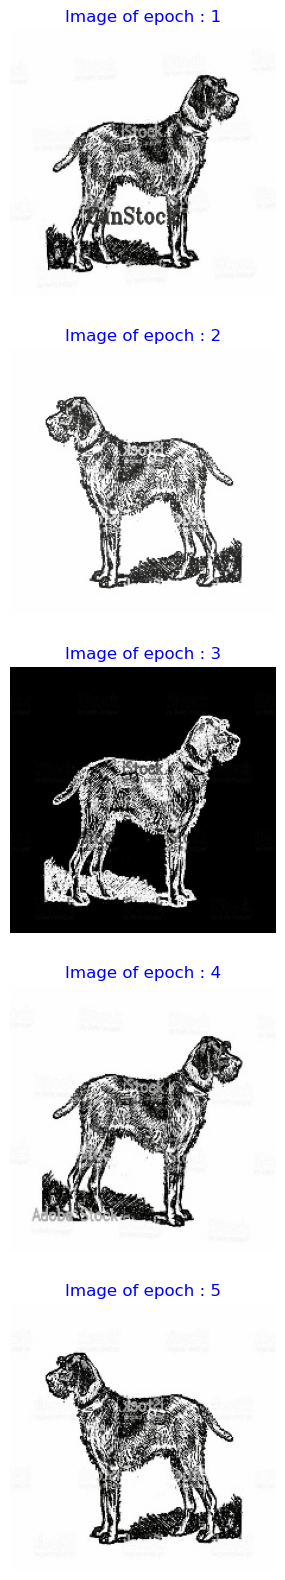

In [37]:
plt.figure(figsize=(20, 20))
for i in range(5):
# OpenCV로 이미지 읽기 (BGR로 읽으므로 RGB로 변환)
    image = cv2.imread(f"{i}epoch_image.jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    
    plt.subplot(5, 1, i+1)
    plt.imshow(image)

    plt.title(f"Image of epoch : {i+1}", color='blue', fontsize=12)

    plt.axis('off')

plt.show()

# Inference

In [38]:
# 모델 추론을 위한 함수
def inference(
    model: nn.Module,
    device: torch.device,
    test_loader: DataLoader
):
    # 모델을 평가 모드로 설정
    model.to(device)
    model.eval()

    predictions = []
    with torch.no_grad():  # Gradient 계산을 비활성화
        for images in tqdm(test_loader):
            # 데이터를 같은 장치로 이동
            images = images.to(device)

            # 모델을 통해 예측 수행
            logits = model(images)
            logits = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)

            # 예측 결과 저장
            predictions.extend(preds.cpu().detach().numpy())  # 결과를 CPU로 옮기고 리스트에 추가

    return predictions

In [39]:
# 추론 데이터의 경로와 정보를 가진 파일의 경로를 설정.
testdata_dir = "./../../data/test"
testdata_info_file = "./../../data/test.csv"
save_result_path = "./train_result"

In [40]:
# 추론 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
test_info = pd.read_csv(testdata_info_file)

# 총 class 수.
num_classes = 500

In [41]:
# 추론에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "albumentations"
)
test_transform = transform_selector.get_transform(is_train=False)

# 추론에 사용할 Dataset을 선언.
test_dataset = CustomDataset(
    root_dir=testdata_dir,
    info_df=test_info,
    transform=test_transform,
    is_inference=True
)

# 추론에 사용할 DataLoader를 선언.
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False
)

In [42]:
# 추론에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 추론에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='timm',
    num_classes=num_classes,
    model_name='resnext50_32x4d.fb_swsl_ig1b_ft_in1k',
    pretrained=True
)
model = model_selector.get_model()


2024-09-20 15:50:44,542 - INFO - Loading pretrained weights from Hugging Face hub (timm/resnext50_32x4d.fb_swsl_ig1b_ft_in1k)
2024-09-20 15:50:44,798 - INFO - [timm/resnext50_32x4d.fb_swsl_ig1b_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-09-20 15:50:44,928 - INFO - Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [43]:
# best epoch 모델을 불러오기.
model.load_state_dict(
    torch.load(
        os.path.join(save_result_path, "best_model.pt"),
        map_location='cpu'
    )
)

C:\Users\Taehan\AppData\Local\Temp\ipykernel_3484\1021875342.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


RuntimeError: Error(s) in loading state_dict for TimmModel:
	Missing key(s) in state_dict: "model.layer1.0.conv3.weight", "model.layer1.0.bn3.weight", "model.layer1.0.bn3.bias", "model.layer1.0.bn3.running_mean", "model.layer1.0.bn3.running_var", "model.layer1.0.downsample.0.weight", "model.layer1.0.downsample.1.weight", "model.layer1.0.downsample.1.bias", "model.layer1.0.downsample.1.running_mean", "model.layer1.0.downsample.1.running_var", "model.layer1.1.conv3.weight", "model.layer1.1.bn3.weight", "model.layer1.1.bn3.bias", "model.layer1.1.bn3.running_mean", "model.layer1.1.bn3.running_var", "model.layer1.2.conv1.weight", "model.layer1.2.bn1.weight", "model.layer1.2.bn1.bias", "model.layer1.2.bn1.running_mean", "model.layer1.2.bn1.running_var", "model.layer1.2.conv2.weight", "model.layer1.2.bn2.weight", "model.layer1.2.bn2.bias", "model.layer1.2.bn2.running_mean", "model.layer1.2.bn2.running_var", "model.layer1.2.conv3.weight", "model.layer1.2.bn3.weight", "model.layer1.2.bn3.bias", "model.layer1.2.bn3.running_mean", "model.layer1.2.bn3.running_var", "model.layer2.0.conv3.weight", "model.layer2.0.bn3.weight", "model.layer2.0.bn3.bias", "model.layer2.0.bn3.running_mean", "model.layer2.0.bn3.running_var", "model.layer2.1.conv3.weight", "model.layer2.1.bn3.weight", "model.layer2.1.bn3.bias", "model.layer2.1.bn3.running_mean", "model.layer2.1.bn3.running_var", "model.layer2.2.conv1.weight", "model.layer2.2.bn1.weight", "model.layer2.2.bn1.bias", "model.layer2.2.bn1.running_mean", "model.layer2.2.bn1.running_var", "model.layer2.2.conv2.weight", "model.layer2.2.bn2.weight", "model.layer2.2.bn2.bias", "model.layer2.2.bn2.running_mean", "model.layer2.2.bn2.running_var", "model.layer2.2.conv3.weight", "model.layer2.2.bn3.weight", "model.layer2.2.bn3.bias", "model.layer2.2.bn3.running_mean", "model.layer2.2.bn3.running_var", "model.layer2.3.conv1.weight", "model.layer2.3.bn1.weight", "model.layer2.3.bn1.bias", "model.layer2.3.bn1.running_mean", "model.layer2.3.bn1.running_var", "model.layer2.3.conv2.weight", "model.layer2.3.bn2.weight", "model.layer2.3.bn2.bias", "model.layer2.3.bn2.running_mean", "model.layer2.3.bn2.running_var", "model.layer2.3.conv3.weight", "model.layer2.3.bn3.weight", "model.layer2.3.bn3.bias", "model.layer2.3.bn3.running_mean", "model.layer2.3.bn3.running_var", "model.layer3.0.conv3.weight", "model.layer3.0.bn3.weight", "model.layer3.0.bn3.bias", "model.layer3.0.bn3.running_mean", "model.layer3.0.bn3.running_var", "model.layer3.1.conv3.weight", "model.layer3.1.bn3.weight", "model.layer3.1.bn3.bias", "model.layer3.1.bn3.running_mean", "model.layer3.1.bn3.running_var", "model.layer3.2.conv1.weight", "model.layer3.2.bn1.weight", "model.layer3.2.bn1.bias", "model.layer3.2.bn1.running_mean", "model.layer3.2.bn1.running_var", "model.layer3.2.conv2.weight", "model.layer3.2.bn2.weight", "model.layer3.2.bn2.bias", "model.layer3.2.bn2.running_mean", "model.layer3.2.bn2.running_var", "model.layer3.2.conv3.weight", "model.layer3.2.bn3.weight", "model.layer3.2.bn3.bias", "model.layer3.2.bn3.running_mean", "model.layer3.2.bn3.running_var", "model.layer3.3.conv1.weight", "model.layer3.3.bn1.weight", "model.layer3.3.bn1.bias", "model.layer3.3.bn1.running_mean", "model.layer3.3.bn1.running_var", "model.layer3.3.conv2.weight", "model.layer3.3.bn2.weight", "model.layer3.3.bn2.bias", "model.layer3.3.bn2.running_mean", "model.layer3.3.bn2.running_var", "model.layer3.3.conv3.weight", "model.layer3.3.bn3.weight", "model.layer3.3.bn3.bias", "model.layer3.3.bn3.running_mean", "model.layer3.3.bn3.running_var", "model.layer3.4.conv1.weight", "model.layer3.4.bn1.weight", "model.layer3.4.bn1.bias", "model.layer3.4.bn1.running_mean", "model.layer3.4.bn1.running_var", "model.layer3.4.conv2.weight", "model.layer3.4.bn2.weight", "model.layer3.4.bn2.bias", "model.layer3.4.bn2.running_mean", "model.layer3.4.bn2.running_var", "model.layer3.4.conv3.weight", "model.layer3.4.bn3.weight", "model.layer3.4.bn3.bias", "model.layer3.4.bn3.running_mean", "model.layer3.4.bn3.running_var", "model.layer3.5.conv1.weight", "model.layer3.5.bn1.weight", "model.layer3.5.bn1.bias", "model.layer3.5.bn1.running_mean", "model.layer3.5.bn1.running_var", "model.layer3.5.conv2.weight", "model.layer3.5.bn2.weight", "model.layer3.5.bn2.bias", "model.layer3.5.bn2.running_mean", "model.layer3.5.bn2.running_var", "model.layer3.5.conv3.weight", "model.layer3.5.bn3.weight", "model.layer3.5.bn3.bias", "model.layer3.5.bn3.running_mean", "model.layer3.5.bn3.running_var", "model.layer4.0.conv3.weight", "model.layer4.0.bn3.weight", "model.layer4.0.bn3.bias", "model.layer4.0.bn3.running_mean", "model.layer4.0.bn3.running_var", "model.layer4.1.conv3.weight", "model.layer4.1.bn3.weight", "model.layer4.1.bn3.bias", "model.layer4.1.bn3.running_mean", "model.layer4.1.bn3.running_var", "model.layer4.2.conv1.weight", "model.layer4.2.bn1.weight", "model.layer4.2.bn1.bias", "model.layer4.2.bn1.running_mean", "model.layer4.2.bn1.running_var", "model.layer4.2.conv2.weight", "model.layer4.2.bn2.weight", "model.layer4.2.bn2.bias", "model.layer4.2.bn2.running_mean", "model.layer4.2.bn2.running_var", "model.layer4.2.conv3.weight", "model.layer4.2.bn3.weight", "model.layer4.2.bn3.bias", "model.layer4.2.bn3.running_mean", "model.layer4.2.bn3.running_var". 
	size mismatch for model.layer1.0.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for model.layer1.0.bn1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer1.0.bn1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer1.0.bn1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer1.0.bn1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer1.0.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 4, 3, 3]).
	size mismatch for model.layer1.0.bn2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer1.0.bn2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer1.0.bn2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer1.0.bn2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer1.1.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1]).
	size mismatch for model.layer1.1.bn1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer1.1.bn1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer1.1.bn1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer1.1.bn1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer1.1.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 4, 3, 3]).
	size mismatch for model.layer1.1.bn2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer1.1.bn2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer1.1.bn2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer1.1.bn2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.layer2.0.conv1.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for model.layer2.0.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer2.0.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer2.0.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer2.0.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer2.0.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 8, 3, 3]).
	size mismatch for model.layer2.0.bn2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer2.0.bn2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer2.0.bn2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer2.0.bn2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer2.0.downsample.0.weight: copying a param with shape torch.Size([128, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for model.layer2.0.downsample.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer2.0.downsample.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer2.0.downsample.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer2.0.downsample.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer2.1.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1]).
	size mismatch for model.layer2.1.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer2.1.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer2.1.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer2.1.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer2.1.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 8, 3, 3]).
	size mismatch for model.layer2.1.bn2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer2.1.bn2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer2.1.bn2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer2.1.bn2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for model.layer3.0.conv1.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for model.layer3.0.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer3.0.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer3.0.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer3.0.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer3.0.conv2.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 16, 3, 3]).
	size mismatch for model.layer3.0.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer3.0.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer3.0.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer3.0.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer3.0.downsample.0.weight: copying a param with shape torch.Size([256, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 512, 1, 1]).
	size mismatch for model.layer3.0.downsample.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer3.0.downsample.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer3.0.downsample.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer3.0.downsample.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer3.1.conv1.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1024, 1, 1]).
	size mismatch for model.layer3.1.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer3.1.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer3.1.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer3.1.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer3.1.conv2.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 16, 3, 3]).
	size mismatch for model.layer3.1.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer3.1.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer3.1.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer3.1.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.layer4.0.conv1.weight: copying a param with shape torch.Size([512, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for model.layer4.0.bn1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer4.0.bn1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer4.0.bn1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer4.0.bn1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer4.0.conv2.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 32, 3, 3]).
	size mismatch for model.layer4.0.bn2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer4.0.bn2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer4.0.bn2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer4.0.bn2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer4.0.downsample.0.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for model.layer4.0.downsample.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for model.layer4.0.downsample.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for model.layer4.0.downsample.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for model.layer4.0.downsample.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for model.layer4.1.conv1.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 2048, 1, 1]).
	size mismatch for model.layer4.1.bn1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer4.1.bn1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer4.1.bn1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer4.1.bn1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer4.1.conv2.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 32, 3, 3]).
	size mismatch for model.layer4.1.bn2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer4.1.bn2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer4.1.bn2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.layer4.1.bn2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.fc.weight: copying a param with shape torch.Size([500, 512]) from checkpoint, the shape in current model is torch.Size([500, 2048]).

In [52]:
# predictions를 CSV에 저장할 때 형식을 맞춰서 저장
# 테스트 함수 호출
predictions = inference(
    model=model,
    device=device,
    test_loader=test_loader
)

  0%|          | 0/157 [00:00<?, ?it/s]

In [53]:
# 모든 클래스에 대한 예측 결과를 하나의 문자열로 합침
test_info['target'] = predictions
test_info = test_info.reset_index().rename(columns={"index": "ID"})
test_info

ID  image_path  target
0          0      0.JPEG     328
1          1      1.JPEG     414
2          2      2.JPEG     493
3          3      3.JPEG      17
4          4      4.JPEG     388
...      ...         ...     ...
10009  10009  10009.JPEG     235
10010  10010  10010.JPEG     191
10011  10011  10011.JPEG     466
10012  10012  10012.JPEG     258
10013  10013  10013.JPEG     210

[10014 rows x 3 columns]

In [54]:
# DataFrame 저장
test_info.to_csv("output.csv", index=False)

In [55]:
import random
import cv2
import matplotlib.pyplot as plt

def visualize_random_images_from_output(output_csv_file, image_dir, train_csv_file, train_image_dir, num_samples=4, figsize=(20, 20)):
    """
    CSV 파일에서 이미지 경로를 무작위로 선택해 시각화하는 함수.

    Parameters:
    - csv_file: 이미지 경로와 라벨이 있는 CSV 파일 경로
    - image_dir: 실제 이미지 파일이 있는 디렉토리 경로
    - num_samples: 시각화할 이미지 개수 (기본값 5)
    - figsize: 출력 이미지 크기 (기본값 (20, 20))
    """

    # CSV 파일 읽기
    output_df = pd.read_csv(output_csv_file)
    train_df = pd.read_csv(train_csv_file)

    # output_df 열에서 무작위로 num_samples 개 선택
    random_samples = output_df.sample(n=num_samples)

    plt.figure(figsize=figsize)

    for i, row in enumerate(random_samples.itertuples()):
        # 이미지 경로 가져오기
        img_path = f"{image_dir}/{row.image_path}"
        label = row.target  # 라벨은 'target' 열에 있다고 가정
        condition = (train_df.target == label)
        label_df = train_df[condition]
        train_img_path = label_df.iloc[0]['image_path']
        train_img_path = f"{train_image_dir}/{train_img_path}"

        # OpenCV로 이미지 읽기 (BGR로 읽으므로 RGB로 변환)
        image = cv2.imread(img_path)
        train_image = cv2.imread(train_img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)

        plt.subplot(int(np.sqrt(num_samples)) * 2, int(np.sqrt(num_samples * 2)) * 2, i * 2 + 1)
        plt.imshow(image)

        # 라벨이 있다면 클래스 이름을 타이틀로 표시
        if 'target' in output_df.columns:
            class_name = str(row.target)  # 라벨은 'target' 열에 있다고 가정
            plt.title(f"Prediction Class: {class_name}", color='blue', fontsize=12)
        else:
            plt.title(f"Image {i+1}", color='blue', fontsize=12)

        plt.axis('off')

        # train 이미지 표시
        plt.subplot(int(np.sqrt(num_samples * 2)) * 2, int(np.sqrt(num_samples * 2)) * 2, i * 2 + 2)
        plt.imshow(train_image)

        # 라벨이 있다면 클래스 이름을 타이틀로 표시
        if 'target' in output_df.columns:
            plt.title(f"Label Class: {class_name}", color='blue', fontsize=12)
        else:
            plt.title(f"Image {i+1}", color='blue', fontsize=12)

        plt.axis('off')

    plt.show()

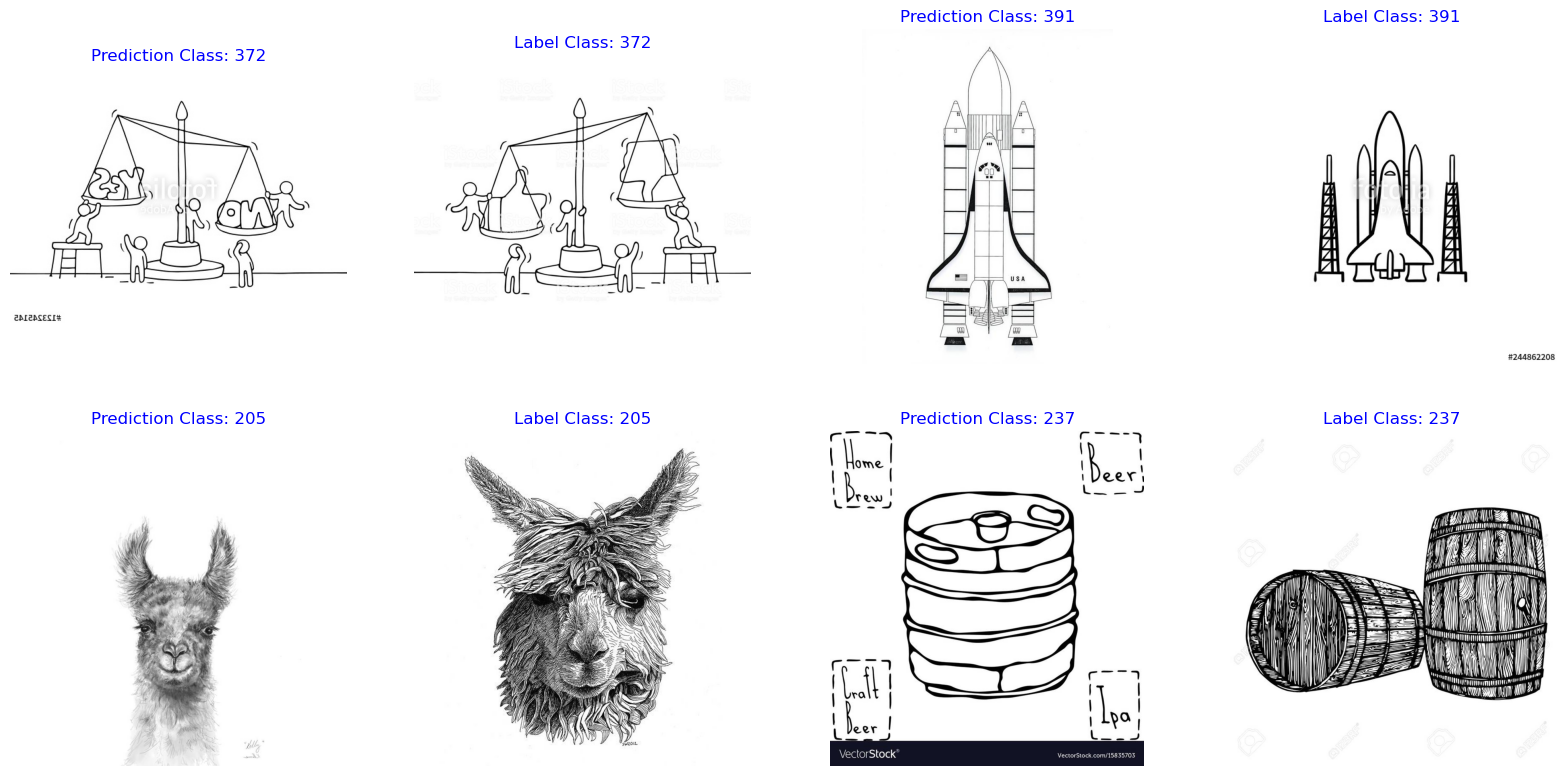

In [69]:
visualize_random_images_from_output("output.csv", testdata_dir, traindata_info_file, traindata_dir)